<a href="https://colab.research.google.com/github/sohumgautam17/nexus_ai_coursework/blob/main/Week3_UNET_Pretrained_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
from torch import nn # This imports the neural network library (All the features we need are here)

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset, Dataset
import torch.nn.functional as F

import monai
from monai.losses import DiceLoss

from torchsummary import summary
from tqdm import tqdm

import os
import glob
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
print(torch.__version__)

2.4.1+cu121


In [2]:
import kagglehub
path = kagglehub.dataset_download("faizalkarim/flood-area-segmentation")
print("Path to dataset files:", path)


100%|██████████| 107M/107M [00:01<00:00, 75.5MB/s] 

Extracting model files...


Path to dataset files: /home/azureuser/.cache/kagglehub/datasets/faizalkarim/flood-area-segmentation/versions/1


In [7]:
def load_dataset(path):
    # Remove leading slash from Image path and fix case
    image_files = sorted(glob.glob(os.path.join(path, "Image/*.jpg")))  # Note: .jpg not .png
    mask_files = sorted(glob.glob(os.path.join(path, "Mask/*.png")))

    images = []
    masks = []

    for img_path, mask_path in zip(image_files, mask_files):
        img = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path))
        images.append(img)
        masks.append(mask)

    return images, masks

# Load all images and masks
images, masks = load_dataset(path)

290
(402, 620, 3)


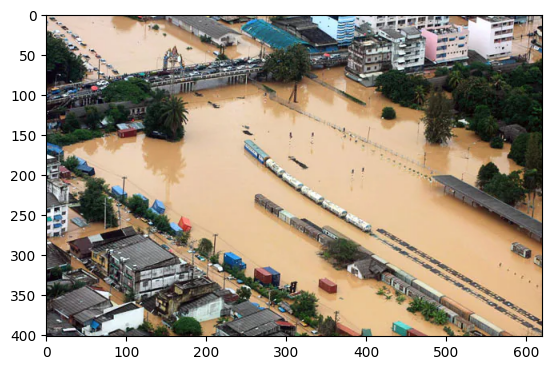

In [8]:
image_num = 289 #@param {type:"raw"}
print(len(images))
print(images[image_num].shape)
plt.imshow(images[image_num])

290
(402, 620)


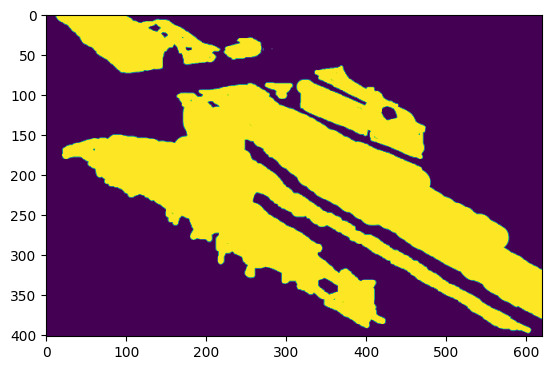

In [9]:
print(len(masks))
print(masks[image_num].shape)
plt.imshow(masks[image_num])

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

image_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], p=1.0)

mask_transform = A.Compose([
    A.Resize(512, 512),
    ToTensorV2()
], p=1.0)

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.1' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


#Custom Dataset

In [11]:
class FloodDataset():
  def __init__(self, images, masks):
    self.images = images
    self.masks = masks

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img = self.images[index]
    mask = self.masks[index]

    img_transformed = image_transform(image=img)['image']
    mask_transformed = mask_transform(image=mask)['image']

    return img_transformed, mask_transformed


In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, masks, test_size=0.2)

print(f'print train images: {len(x_train)} train masks: {len(y_train)}')
print(f'print test images: {len(x_test)} test masks: {len(y_test)}')

print train images: 232 train masks: 232
print test images: 58 test masks: 58


In [13]:
train_dataset = FloodDataset(x_train, y_train)
test_dataset = FloodDataset(x_test, y_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 512])


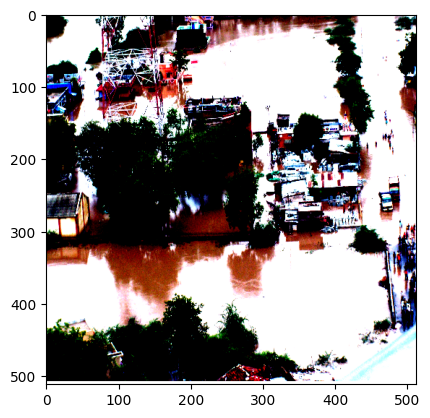

In [20]:
print(train_dataset[2][0].shape)
plt.imshow(train_dataset[2][0].permute(1, 2, 0))

In [15]:
train_dataset[2][1].shape

torch.Size([1, 512, 512])

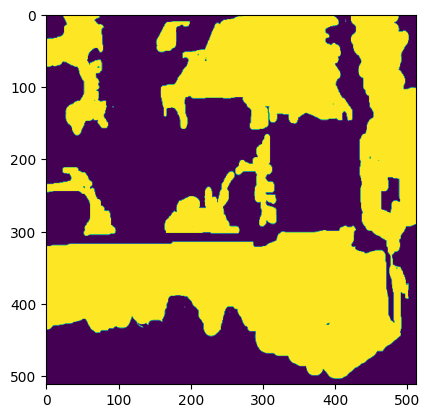

In [16]:
plt.imshow(train_dataset[2][1].permute(1, 2, 0))

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

#Model

![An Image](https://neuron-ai.at/wp-content/uploads/2022/11/neuronai-image-segmentation-segnet-architecture.png)


In [18]:
class Double_Conv(nn.Module):
  def __init__(self, in_channels, mid_channels, out_channels):
    super().__init__()
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),

        nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
  def forward(self, x):
    return self.double_conv(x)


class Downsample(nn.Module):
  def __init__(self, in_channels, mid_channels, out_channels):
    super().__init__()
    self.downsample =  nn.Sequential(
      nn.MaxPool2d(kernel_size=2, stride=2),
      Double_Conv(in_channels, mid_channels, out_channels)
  )

  def forward(self, x):
    return self.downsample(x)


class Upsample(nn.Module):
  def __init__(self, in_channels, mid_channels, out_channels):
    super().__init__()
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.conv = Double_Conv(in_channels, mid_channels, out_channels)

  def forward(self, up_x, res_x):
    x = self.upsample(up_x)

    # print(up_x.size())
    # print(res_x.size())

    diffY = x.size()[2] - res_x.size()[2]
    diffX = x.size()[3] - res_x.size()[3]

    x = F.pad(x, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])

    x = torch.cat([res_x, x], dim=1)

    return self.conv(x)

class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

  def forward(self, x):
    return self.conv(x)

In [21]:
class Unet(nn.Module):
  def __init__(self):
    super(Unet, self).__init__()
    self.down1 = Downsample(3, 64, 128)
    self.down2 = Downsample(128, 128, 256)
    self.down3 = Downsample(256, 256, 512)
    self.down4 = Downsample(512, 512, 1024)
    # For up1: 1024 + 512 = 1536 input channels after concat
    self.up1 = Upsample(1536, 512, 512)
    # For up2: 512 + 256 = 768 input channels after concat
    self.up2 = Upsample(768, 256, 256)
    # For up3: 256 + 128 = 384 input channels after concat
    self.up3 = Upsample(384, 128, 128)
    # For up4: 128 + 3 = 131 input channels after concat
    self.up4 = Upsample(131, 64, 64)
    self.outc = OutConv(64, 1)

  def forward(self, x):
    x1 = self.down1(x)
    x2 = self.down2(x1)
    x3 = self.down3(x2)
    x4 = self.down4(x3)
    x5 = self.up1(x4, x3)
    x6 = self.up2(x5, x2)
    x7 = self.up3(x6, x1)
    x8 = self.up4(x7, x)
    return self.outc(x8)

model = Unet()

In [ ]:
summary(model, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         MaxPool2d-1          [-1, 3, 256, 256]               0
            Conv2d-2         [-1, 64, 256, 256]           1,792
       BatchNorm2d-3         [-1, 64, 256, 256]             128
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 256, 256]          73,856
       BatchNorm2d-6        [-1, 128, 256, 256]             256
              ReLU-7        [-1, 128, 256, 256]               0
       Double_Conv-8        [-1, 128, 256, 256]               0
        Downsample-9        [-1, 128, 256, 256]               0
        MaxPool2d-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
           Conv2d-14        [-1, 256, 1

In [23]:
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
dice_loss = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train(model, train_loader, test_loader, criterion, dice_loss, optimizer, num_epochs=10, device="cuda"):
#    model = model.to(device)

   for epoch in range(num_epochs):
       model.train()
       train_loss = 0

       for batch_idx, (data, target) in tqdm(enumerate(train_loader), desc='Training'):
            # data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)

            print(output.dtype)
            print(target.dtype)
            
            target = target.to(torch.float32)
            # Combine BCE and Dice loss
            loss = criterion(output, target) + dice_loss(output, target)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if batch_idx % 1 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')

       # Validation
       model.eval()
       val_loss = 0

       with torch.no_grad():
           for data, target in tqdm(test_loader):
            #    data, target = data.to(device), target.to(device)
               output = model(data)
               val_loss += (criterion(output, target) + dice_loss(output, target)).item()

       print(f'Epoch {epoch}: Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}')

# Train
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

# input()
# criterion = criterion.to(device)
# dice_loss = dice_loss.to(device)

train(model, train_dataloader, test_dataloader, criterion, dice_loss, optimizer, num_epochs=10)


0it [00:00, ?it/s]

torch.float32
torch.uint8


1it [00:50, 50.41s/it]

Epoch: 0, Batch: 0, Loss: 1.8569
torch.float32
torch.uint8


2it [01:38, 49.13s/it]

Epoch: 0, Batch: 1, Loss: 1.8156
torch.float32
torch.uint8


3it [02:30, 50.40s/it]

Epoch: 0, Batch: 2, Loss: 1.8541
torch.float32
torch.uint8


4it [03:18, 49.48s/it]

Epoch: 0, Batch: 3, Loss: 1.8460
torch.float32
torch.uint8


5it [04:11, 50.58s/it]

Epoch: 0, Batch: 4, Loss: 1.8606
torch.float32
torch.uint8


6it [04:59, 49.66s/it]

Epoch: 0, Batch: 5, Loss: 1.8149
torch.float32
torch.uint8


7it [05:48, 49.48s/it]

Epoch: 0, Batch: 6, Loss: 1.8150
torch.float32
torch.uint8


8it [06:37, 49.31s/it]

Epoch: 0, Batch: 7, Loss: 1.8139
torch.float32
torch.uint8


9it [07:25, 49.10s/it]

Epoch: 0, Batch: 8, Loss: 1.7941
torch.float32
torch.uint8


10it [08:13, 48.73s/it]

Epoch: 0, Batch: 9, Loss: 1.8211
torch.float32
torch.uint8


11it [09:01, 48.50s/it]

Epoch: 0, Batch: 10, Loss: 1.7870
torch.float32
torch.uint8


12it [09:48, 48.09s/it]

Epoch: 0, Batch: 11, Loss: 1.8966
torch.float32
torch.uint8


13it [10:35, 47.76s/it]

Epoch: 0, Batch: 12, Loss: 1.8048
torch.float32
torch.uint8


14it [11:22, 47.52s/it]

Epoch: 0, Batch: 13, Loss: 1.8458
torch.float32
torch.uint8


15it [12:09, 47.44s/it]

Epoch: 0, Batch: 14, Loss: 1.8161
torch.float32
torch.uint8


16it [12:58, 47.65s/it]

Epoch: 0, Batch: 15, Loss: 1.8199
torch.float32
torch.uint8


17it [13:45, 47.62s/it]

Epoch: 0, Batch: 16, Loss: 1.8411
torch.float32
torch.uint8


18it [14:32, 47.48s/it]

Epoch: 0, Batch: 17, Loss: 1.8378
torch.float32
torch.uint8


19it [15:20, 47.49s/it]

Epoch: 0, Batch: 18, Loss: 1.7991
torch.float32
torch.uint8


20it [16:07, 47.37s/it]

Epoch: 0, Batch: 19, Loss: 1.8263
torch.float32
torch.uint8


In [ ]:
def ensure_dir_exist(director_path):
    if not os.path.exist(director_path):
        os.makedirs(directory_path)
        print(directory_path)    
    else: 
        print("Directory Already exists")

In [ ]:
model_weights_path = ""
ensure_dir_exist(model_weights_path)
torch.save(model.state_dict(), model_weights_path)